In [1]:
# Load basic packages
import numpy as np
import pandas as pd

import autograd.numpy as numpy
import autograd.numpy.random as npr

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection

# Useful for saving our models.
import pickle
print("Imported all!")

df = pd.read_csv('diabetes.csv')
df = df.dropna()
diabetes = df.values
print("Shape of the loaded dataset: {} rows and {} columns.".format(diabetes.shape[0], diabetes.shape[1]))
df.head()

Imported all!
Shape of the loaded dataset: 253680 rows and 22 columns.


,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,...,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,1,11,5,4,8


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Sample data
data = diabetes

# Define columns
categorical_cols = [17, 21]  # Indices of categorical columns (sex + zodiac sign)
# We are not going to touch the ordinal data anyhow, since it is already giving the appropriate weights to the model
# ordinal_cols = [18, 19, 20]  # Indices of ordinal columns (age, education, income)
continuous_cols = [3, 13, 14, 15]  # Indices of continuous columns (BMI, general health, mental health, physical health)

# One-Hot Encoding for categorical variables

# pass the numpy column to the data to make this transofrmantion happen
def categorical_to_ohe(data, col_idx):
    one_hot_encoded_data = []
    categorical_column = data[:, col_idx]
    
    # for col_idx in categorical_cols:
    unique_values = np.unique(categorical_column)
    for value in unique_values[:-1]:  # Exclude the last category to avoid the dummy variable trap
        one_hot_encoded_data.append((data[:, col_idx] == value).astype(int))
    
    return np.array(one_hot_encoded_data).T

# Normalization for continuous variables (using Min-Max scaling to scale between 0 and 1)
def normalize_continious_variables(data, col_idx):
    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(data[:, col_idx].reshape(-1, 1))
    return scaled

# Standardization for ordinal variables (using Standard scaling with mean 0 and STD of 1)
def standardize_ordinal_variables(data, col_idx):
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    scaled = scaler.fit_transform(data[:, col_idx].reshape(-1, 1))
    return scaled


ready_to_use_columns_p1 = [1, 2]
# Scale continious variables
normalized_BMI = standardize_ordinal_variables(data, 3)
ready_to_use_columns_p2 = [i for i in range(4, 13)]
normalized_general_health = standardize_ordinal_variables(data, 13)
normalized_mental_health = standardize_ordinal_variables(data, 14)
normalized_physical_health = standardize_ordinal_variables(data, 15)

# transform the sex column into OHE (one column only - no dummy variable trap)
sex_one_hot_encoded = categorical_to_ohe(data, 17)
# Let's now scale the ordinal columns (bracket values)
normalized_age = standardize_ordinal_variables(data, 18)
normalized_education = standardize_ordinal_variables(data, 19)
normalized_income = standardize_ordinal_variables(data, 20)

# We are not using this one for the models, as it is unnecessary and adds a lot of dimensions
zodiac_one_hot_encoded = categorical_to_ohe(data, 21)


# Now, combine all the columns back together
processed_data = np.concatenate((
    # 1 and 2 are as is
    data[:, ready_to_use_columns_p1],
    # BMI is normalized
    normalized_BMI,
    # [4-13] are as is
    data[:, ready_to_use_columns_p2],
    # health predictors are normalized
    normalized_general_health, 
    normalized_mental_health, 
    normalized_physical_health,
    # 16 is as is
    data[:, 16].reshape(-1, 1),
    # 17 is OHE
    sex_one_hot_encoded,
    # age, education, and income brackets are normalized
    normalized_age,
    normalized_education, 
    normalized_income,
    # zodiac_one_hot_encoded
), axis=1)

# column names
column_names = [
    "High blood pressure", 
    "High cholesterol", 
    "Body Mass Index", 
    "Smoker", 
    "Stroke", 
    "Myocardial issues", 
    "Physically active", 
    "Eats fruit", 
    "Eats vegetables", 
    "Heavy Drinker", 
    "Has healthcare", 
    "Cannot Afford Doctor", 
    "General health", 
    "Mental health", 
    "Physical health", 
    "Hard to climb stairs", 
    "Biological sex", 
    "Age bracket", 
    "Education bracket", 
    "Income bracket"
    # "Zodiac sign"
]

# let's check that our predictor names correspond properly
print(processed_data.shape[1] == len(column_names))

idx_to_predictor = {}
predictor_to_idx = {}

for idx, predictor in enumerate(column_names):
    idx_to_predictor[idx] = column_names[idx]
    predictor_to_idx[predictor] = idx

y = diabetes[:, 0]  # the outcome is in the first column
X = processed_data
if X.shape[0] == y.shape[0]:
    print("Column numbers match! Data is ready to be used!")
    
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.2, random_state=7) # 0.2 is 20% test data.

True
Column numbers match! Data is ready to be used!


# Question 1: Building a perceptron

###  What is the AUC of this model?

Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.90      0.89     43542
           1       0.34      0.33      0.33      7194

    accuracy                           0.82     50736
   macro avg       0.62      0.61      0.61     50736
weighted avg       0.81      0.82      0.81     50736



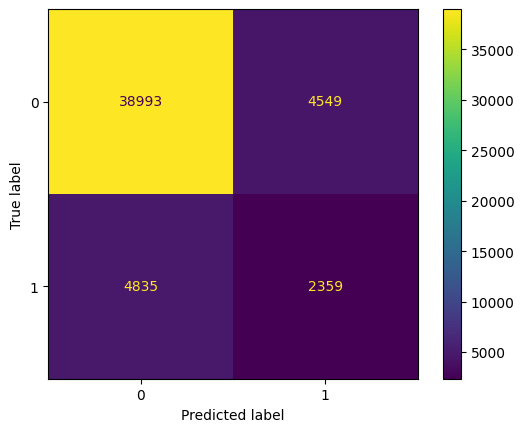

In [3]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

perceptron = Perceptron(tol=1e-3, random_state=0, shuffle=True)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)

report = classification_report(y_test, y_pred)
print("Classification Report:\n\n", report)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=perceptron.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=perceptron.classes_)
disp.plot()

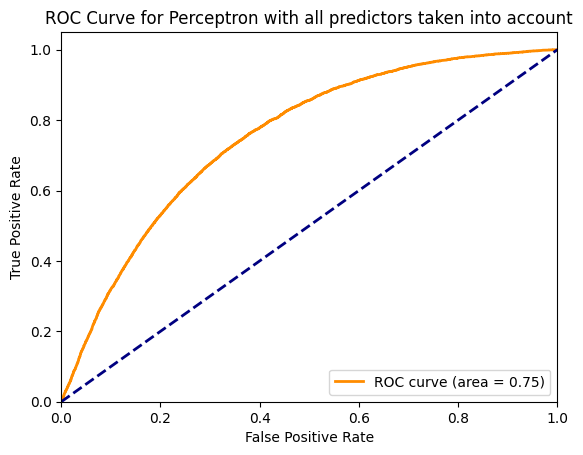

AUC score of the model:  0.7520561634514251


In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

decision_values = perceptron.decision_function(X_test)
predicted_probabilities = (decision_values - decision_values.min()) / (decision_values.max() - decision_values.min())
true_labels = y_test
auc_score_full_model = roc_auc_score(true_labels, predicted_probabilities)

def graph_auc_curve_log_reg(model, predicted_probabilities, true_labels, title="all predictors taken into account"):
    # calculate false positive rates, true positive rates, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    # calculate the roc_auc_score
    auc_score = roc_auc_score(true_labels, predicted_probabilities)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC Curve for Perceptron with {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

graph_auc_curve_log_reg(perceptron, predicted_probabilities, true_labels)
print("AUC score of the model: ", auc_score_full_model)

# --------------------------------------------------------------------------

# Question 2: Building a feedforward network with one layer

### How does AUC vary as a function of the number of hidden layers and is it dependent on the kind of activation function used (make sure to include “no activation function” in your comparison). How does this network perform relative to the Perceptron?

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.as_tensor(X_train, dtype=torch.float)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.float)
X_test_tensor = torch.as_tensor(X_test, dtype=torch.float)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.float)

In [6]:
class FlexibleFC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden_layers, hidden_size, output_size, activation=''):
        super(FlexibleFC2Layer, self).__init__()
        self.input_size = input_size
        self.n_hidden_layers = n_hidden_layers
        self.hidden_size = hidden_size

        if activation == 'relu':
            self.activation = nn.ReLU()  
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            # Activation function not implemented, using default Identity
            self.activation = nn.Identity()

        layers = []
        # Add input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(self.activation)

        # Add hidden layers
        for _ in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(self.activation)

        # Add output layer
        layers.append(nn.Linear(hidden_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

# architecture hyperparameters 
D = X_train.shape[1]  # input dimensions

# Define training hyperparameters
learning_rate = 1e-3
lambda_l2 = 1e-2

n_hidden_units = [5, 15, 45]
activation_functions = ['relu', 'sigmoid', 'identity']
one_layer_models = []

for units_per_layer in n_hidden_units:
    for activation_func in activation_functions:
        one_layer_model = FlexibleFC2Layer(input_size=D, n_hidden_layers=1, hidden_size=units_per_layer, output_size=1, activation=activation_func)
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(one_layer_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
        one_layer_models.append({"model": one_layer_model, "loss_function": loss_function, "optimizer": optimizer})
one_layer_models

[{'model': FlexibleFC2Layer(
    (activation): ReLU()
    (network): Sequential(
      (0): Linear(in_features=20, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=1, bias=True)
    )
  ),
  'loss_function': CrossEntropyLoss(),
  'optimizer': SGD (
  Parameter Group 0
      dampening: 0
      differentiable: False
      foreach: None
      lr: 0.001
      maximize: False
      momentum: 0
      nesterov: False
      weight_decay: 0.01
  )},
 {'model': FlexibleFC2Layer(
    (activation): Sigmoid()
    (network): Sequential(
      (0): Linear(in_features=20, out_features=5, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=5, out_features=1, bias=True)
    )
  ),
  'loss_function': CrossEntropyLoss(),
  'optimizer': SGD (
  Parameter Group 0
      dampening: 0
      differentiable: False
      foreach: None
      lr: 0.001
      maximize: False
      momentum: 0
      nesterov: False
      weight_decay: 0.01
  )},
 {'model': FlexibleF

In [7]:
from sklearn.metrics import mean_squared_error

def train_model(model, criterion, optimizer, inputs, labels, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        epoch_loss = loss.item()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
           print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

auc_scores = []
rmse_scores = []

# pass testing tensors for these:
def estimate_auc_rmse_scores(model, input_tensor, true_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
    return (roc_auc_score(true_labels.numpy(), outputs.numpy()), np.sqrt(mean_squared_error(true_labels.numpy(), outputs.numpy())), model)
    

for idx, model_info in enumerate(one_layer_models):
    model = model_info["model"]
    loss_function = model_info["loss_function"]
    optimizer = model_info["optimizer"]
    
    print("\nTraining #{} starts".format(idx))
    
    train_model(model, criterion=loss_function, optimizer=optimizer, inputs=X_train_tensor, labels=y_train_tensor)
    
    metrics = estimate_auc_rmse_scores(model, X_test_tensor, y_test_tensor)
    auc_scores.append(metrics[0])
    rmse_scores.append(metrics[1])
    
    print("\n\n")

print(auc_scores)
print(rmse_scores)


Training #0 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #1 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #2 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #3 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #4 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #5 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
E

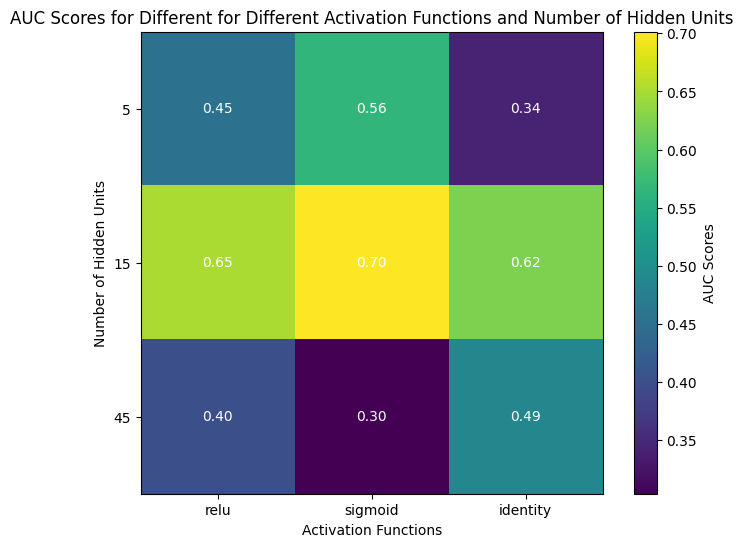

In [8]:
import numpy as np
import matplotlib.pyplot as plt

auc_scores = np.array(auc_scores).reshape(len(n_hidden_units), len(activation_functions))

plt.figure(figsize=(8, 6))
plt.imshow(auc_scores, cmap='viridis', interpolation='nearest')
plt.colorbar(label='AUC Scores')

# Set ticks and labels for axes
plt.xticks(np.arange(len(activation_functions)), activation_functions)
plt.yticks(np.arange(len(n_hidden_units)), n_hidden_units)
plt.xlabel('Activation Functions')
plt.ylabel('Number of Hidden Units')

# Add text annotations for each cell
for i in range(len(n_hidden_units)):
    for j in range(len(activation_functions)):
        plt.text(j, i, f'{auc_scores[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('AUC Scores for Different for Different Activation Functions and Number of Hidden Units')
plt.show()

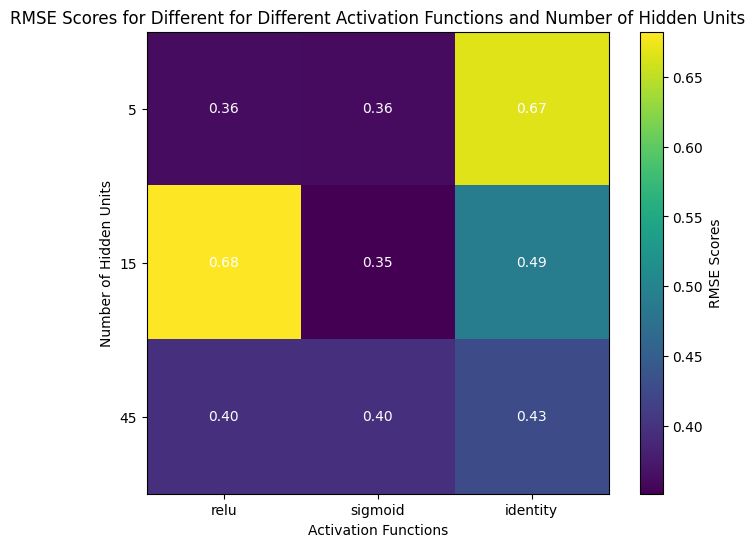

In [9]:
rmse_scores = np.array(rmse_scores).reshape(len(n_hidden_units), len(activation_functions))

plt.figure(figsize=(8, 6))
plt.imshow(rmse_scores, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RMSE Scores')

plt.xticks(np.arange(len(activation_functions)), activation_functions)
plt.yticks(np.arange(len(n_hidden_units)), n_hidden_units)
plt.xlabel('Activation Functions')
plt.ylabel('Number of Hidden Units')

# Add text annotations for each cell
for i in range(len(n_hidden_units)):
    for j in range(len(activation_functions)):
        plt.text(j, i, f'{rmse_scores[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('RMSE Scores for Different for Different Activation Functions and Number of Hidden Units')
plt.show()

# Question 3: Building a deep network with 2+ layers

### Given the nature of this dataset, is there a benefit of using a CNN for the classification?

In [10]:
n_hidden_layers = [2, 3, 5]
deep_models = []
for n_layers in n_hidden_layers:
    for activation_func in activation_functions:
        deep_model = FlexibleFC2Layer(input_size=D, n_hidden_layers=n_layers, hidden_size=15, output_size=1, activation=activation_func)
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(deep_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
        deep_models.append({"model": deep_model, "loss_function": loss_function, "optimizer": optimizer})

deep_models

[{'model': FlexibleFC2Layer(
    (activation): ReLU()
    (network): Sequential(
      (0): Linear(in_features=20, out_features=15, bias=True)
      (1): ReLU()
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): ReLU()
      (4): Linear(in_features=15, out_features=1, bias=True)
    )
  ),
  'loss_function': CrossEntropyLoss(),
  'optimizer': SGD (
  Parameter Group 0
      dampening: 0
      differentiable: False
      foreach: None
      lr: 0.001
      maximize: False
      momentum: 0
      nesterov: False
      weight_decay: 0.01
  )},
 {'model': FlexibleFC2Layer(
    (activation): Sigmoid()
    (network): Sequential(
      (0): Linear(in_features=20, out_features=15, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=15, out_features=1, bias=True)
    )
  ),
  'loss_function': CrossEntropyLoss(),
  'optimizer': SGD (
  Parameter Group 0
      dampening: 0
      diff

In [11]:
auc_scores = []
rmse_scores = []

for idx, model_info in enumerate(deep_models):
    model = model_info["model"]
    loss_function = model_info["loss_function"]
    optimizer = model_info["optimizer"]
    
    print("\nTraining #{} starts".format(idx))
    
    train_model(model, criterion=loss_function, optimizer=optimizer, inputs=X_train_tensor, labels=y_train_tensor)
    
    metrics = estimate_auc_rmse_scores(model, X_test_tensor, y_test_tensor)
    auc_scores.append(metrics[0])
    rmse_scores.append(metrics[1])
    
    print("\n\n")

print(auc_scores)
print(rmse_scores)


Training #0 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #1 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #2 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #3 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #4 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
Epoch [81/100], Loss: -0.0000




Training #5 starts
Epoch [1/100], Loss: -0.0000
Epoch [21/100], Loss: -0.0000
Epoch [41/100], Loss: -0.0000
Epoch [61/100], Loss: -0.0000
E

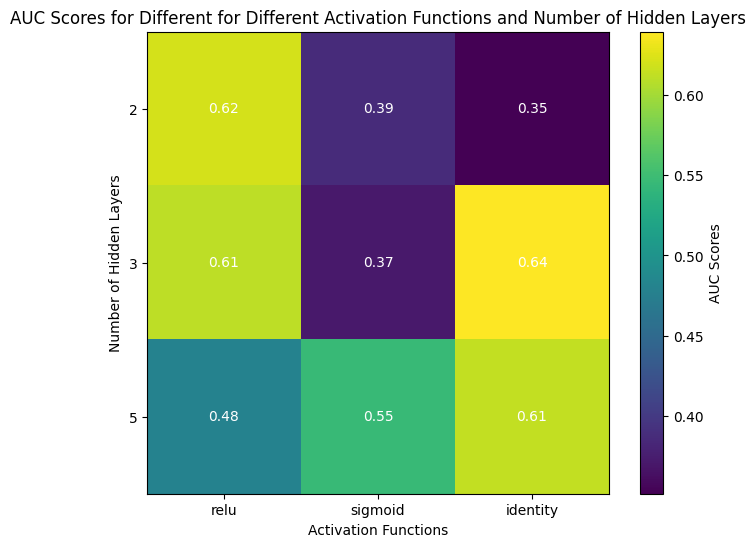

In [12]:
auc_scores = np.array(auc_scores).reshape(len(n_hidden_layers), len(activation_functions))

plt.figure(figsize=(8, 6))
plt.imshow(auc_scores, cmap='viridis', interpolation='nearest')
plt.colorbar(label='AUC Scores')

plt.xticks(np.arange(len(activation_functions)), activation_functions)
plt.yticks(np.arange(len(n_hidden_layers)), n_hidden_layers)
plt.xlabel('Activation Functions')
plt.ylabel('Number of Hidden Layers')

for i in range(len(n_hidden_layers)):
    for j in range(len(activation_functions)):
        plt.text(j, i, f'{auc_scores[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('AUC Scores for Different for Different Activation Functions and Number of Hidden Layers')
plt.show()

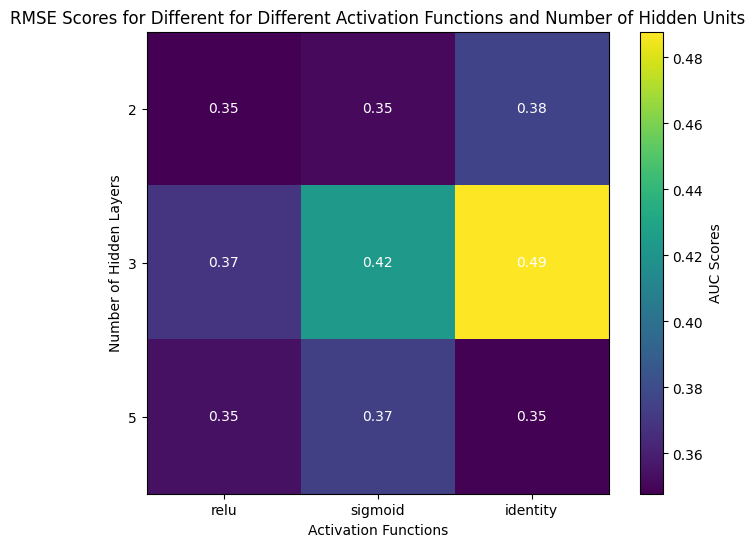

In [13]:
rmse_scores = np.array(rmse_scores).reshape(len(n_hidden_layers), len(activation_functions))

plt.figure(figsize=(8, 6))
plt.imshow(rmse_scores, cmap='viridis', interpolation='nearest')
plt.colorbar(label='AUC Scores')

plt.xticks(np.arange(len(activation_functions)), activation_functions)
plt.yticks(np.arange(len(n_hidden_layers)), n_hidden_layers)
plt.xlabel('Activation Functions')
plt.ylabel('Number of Hidden Layers')

for i in range(len(n_hidden_layers)):
    for j in range(len(activation_functions)):
        plt.text(j, i, f'{rmse_scores[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('RMSE Scores for Different for Different Activation Functions and Number of Hidden Units')
plt.show()

# Question 4: feedforward neural network with one hidden layer to predict BMI

In [14]:
# Now, combine all the columns back together
processed_data = np.concatenate((
    # diabetes
    data[:, 0].reshape(-1, 1),
    # 1 and 2 are as is
    data[:, ready_to_use_columns_p1],
    # [4-13] are as is
    data[:, ready_to_use_columns_p2],
    # health predictors are normalized
    normalized_general_health, 
    normalized_mental_health, 
    normalized_physical_health,
    # 16 is as is
    data[:, 16].reshape(-1, 1),
    # 17 is OHE
    sex_one_hot_encoded,
    # age, education, and income brackets are normalized
    normalized_age,
    normalized_education, 
    normalized_income,
    # zodiac_one_hot_encoded
), axis=1)

# column names
column_names = [
    "Diabetes",
    "High blood pressure", 
    "High cholesterol", 
    "Smoker", 
    "Stroke", 
    "Myocardial issues", 
    "Physically active", 
    "Eats fruit", 
    "Eats vegetables", 
    "Heavy Drinker", 
    "Has healthcare", 
    "Cannot Afford Doctor", 
    "General health", 
    "Mental health", 
    "Physical health", 
    "Hard to climb stairs", 
    "Biological sex", 
    "Age bracket", 
    "Education bracket", 
    "Income bracket"
]

y = data[:, 3]  # the outcome is in the third column
X = processed_data
if X.shape[0] == y.shape[0]:
    print("Column numbers match! Data is ready to be used!")
    
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.2, random_state=7) # 0.2 is 20% test data.

X_train_tensor = torch.as_tensor(X_train, dtype=torch.float)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.float)
X_test_tensor = torch.as_tensor(X_test, dtype=torch.float)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.float)

Column numbers match! Data is ready to be used!


In [15]:
# architecture hyperparameters 
D = X_train.shape[1]  # input dimensions

# Define training hyperparameters
learning_rates = [1e-4, 1e-3, 1e-2]
lambda_l2s = [1e-4, 1e-3, 1e-2]

n_hidden_units = [5, 15, 45]
activation_functions = ['relu', 'sigmoid', 'identity']
one_layer_models = []
i = 0

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

for learning_rate in learning_rates:
    for lambda_l2 in lambda_l2s:
        for units_per_layer in n_hidden_units:
            for activation_func in activation_functions:
                one_layer_model = FlexibleFC2Layer(input_size=D, n_hidden_layers=1, hidden_size=units_per_layer, output_size=1, activation=activation_func)
                loss_function = RMSELoss()
                optimizer = torch.optim.SGD(one_layer_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
                one_layer_models.append({"model": one_layer_model, "loss_function": loss_function, "optimizer": optimizer, "idx": i})
                i += 1
len(one_layer_models)

81

In [16]:
rmse_scores = []
model_infos = []

def estimate_auc_rmse_scores(model, input_tensor, true_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
    return (np.sqrt(mean_squared_error(true_labels.numpy(), outputs.squeeze().detach().numpy())), model)   

for idx, model_info in enumerate(one_layer_models):
    model = model_info["model"]
    loss_function = model_info["loss_function"]
    optimizer = model_info["optimizer"]
    
    print("\nTraining #{} starts".format(idx))
    
    train_model(model, criterion=loss_function, optimizer=optimizer, inputs=X_train_tensor, labels=y_train_tensor)
    
    metrics = estimate_auc_rmse_scores(model, X_test_tensor, y_test_tensor)
    rmse_scores.append(metrics[0])
    model_infos.append(metrics[1])
    
    print("\n\n")


Training #0 starts
Epoch [1/100], Loss: 29.6170
Epoch [21/100], Loss: 29.6119
Epoch [41/100], Loss: 29.6068
Epoch [61/100], Loss: 29.6017
Epoch [81/100], Loss: 29.5966




Training #1 starts
Epoch [1/100], Loss: 28.6876
Epoch [21/100], Loss: 28.6827
Epoch [41/100], Loss: 28.6778
Epoch [61/100], Loss: 28.6728
Epoch [81/100], Loss: 28.6679




Training #2 starts
Epoch [1/100], Loss: 28.7510
Epoch [21/100], Loss: 28.7464
Epoch [41/100], Loss: 28.7417
Epoch [61/100], Loss: 28.7370
Epoch [81/100], Loss: 28.7323




Training #3 starts
Epoch [1/100], Loss: 29.4047
Epoch [21/100], Loss: 29.4003
Epoch [41/100], Loss: 29.3959
Epoch [61/100], Loss: 29.3914
Epoch [81/100], Loss: 29.3870




Training #4 starts
Epoch [1/100], Loss: 29.0618
Epoch [21/100], Loss: 29.0527
Epoch [41/100], Loss: 29.0437
Epoch [61/100], Loss: 29.0346
Epoch [81/100], Loss: 29.0255




Training #5 starts
Epoch [1/100], Loss: 29.2340
Epoch [21/100], Loss: 29.2267
Epoch [41/100], Loss: 29.2193
Epoch [61/100], Loss: 29.2120
E

In [17]:
min_rmse_idx = rmse_scores.index(min(rmse_scores))
print(min_rmse_idx)

print("Model params with the lowest RMSE: \n\n{}".format(model_infos[min_rmse_idx]))

80
Model params with the lowest RMSE: 

FlexibleFC2Layer(
  (activation): Identity()
  (network): Sequential(
    (0): Linear(in_features=20, out_features=45, bias=True)
    (1): Identity()
    (2): Linear(in_features=45, out_features=1, bias=True)
  )
)


In [18]:
# let's now extract the basic paramaters we deduced to with our model

for model_info in one_layer_models:
    if model_info["idx"] == 71:
        print(model_info)

{'model': FlexibleFC2Layer(
  (activation): Identity()
  (network): Sequential(
    (0): Linear(in_features=20, out_features=45, bias=True)
    (1): Identity()
    (2): Linear(in_features=45, out_features=1, bias=True)
  )
), 'loss_function': RMSELoss(
  (mse): MSELoss()
), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0.001
), 'idx': 71}


In [19]:
coordinates = []
one_layer_models = []
i, j = 0, 0
for units_per_layer in n_hidden_units:
    for activation_func in activation_functions:
        one_layer_model = FlexibleFC2Layer(input_size=D, n_hidden_layers=1, hidden_size=units_per_layer, output_size=1, activation=activation_func)
        loss_function = RMSELoss()
        optimizer = torch.optim.SGD(one_layer_model.parameters(), lr=0.01, weight_decay=0.001) # built-in L2
        one_layer_models.append({"model": one_layer_model, "loss_function": loss_function, "optimizer": optimizer, "idx": i})
        j += 1
    i += 1
    coordinates.append((i, j))
print(len(one_layer_models))

9


In [20]:
rmse_scores = []
for idx, model_info in enumerate(one_layer_models):
    model = model_info["model"]
    loss_function = model_info["loss_function"]
    optimizer = model_info["optimizer"]
    
    print("\nTraining #{} starts".format(idx))
    
    train_model(model, criterion=loss_function, optimizer=optimizer, inputs=X_train_tensor, labels=y_train_tensor)
    
    metrics = estimate_auc_rmse_scores(model, X_test_tensor, y_test_tensor)
    rmse_scores.append(metrics[0])
    
    print("\n\n")

print(rmse_scores)


Training #0 starts
Epoch [1/100], Loss: 29.3470
Epoch [21/100], Loss: 29.0225
Epoch [41/100], Loss: 28.5644
Epoch [61/100], Loss: 27.7621
Epoch [81/100], Loss: 26.1793




Training #1 starts
Epoch [1/100], Loss: 28.7317
Epoch [21/100], Loss: 28.2499
Epoch [41/100], Loss: 27.7484
Epoch [61/100], Loss: 27.2167
Epoch [81/100], Loss: 26.6452




Training #2 starts
Epoch [1/100], Loss: 29.5144
Epoch [21/100], Loss: 28.8001
Epoch [41/100], Loss: 27.8281
Epoch [61/100], Loss: 26.0664
Epoch [81/100], Loss: 22.5255




Training #3 starts
Epoch [1/100], Loss: 29.1870
Epoch [21/100], Loss: 28.6972
Epoch [41/100], Loss: 27.9592
Epoch [61/100], Loss: 26.6136
Epoch [81/100], Loss: 23.9191




Training #4 starts
Epoch [1/100], Loss: 29.4637
Epoch [21/100], Loss: 28.5614
Epoch [41/100], Loss: 27.6542
Epoch [61/100], Loss: 26.7150
Epoch [81/100], Loss: 25.7173




Training #5 starts
Epoch [1/100], Loss: 28.8030
Epoch [21/100], Loss: 28.0998
Epoch [41/100], Loss: 26.9009
Epoch [61/100], Loss: 24.5399
E

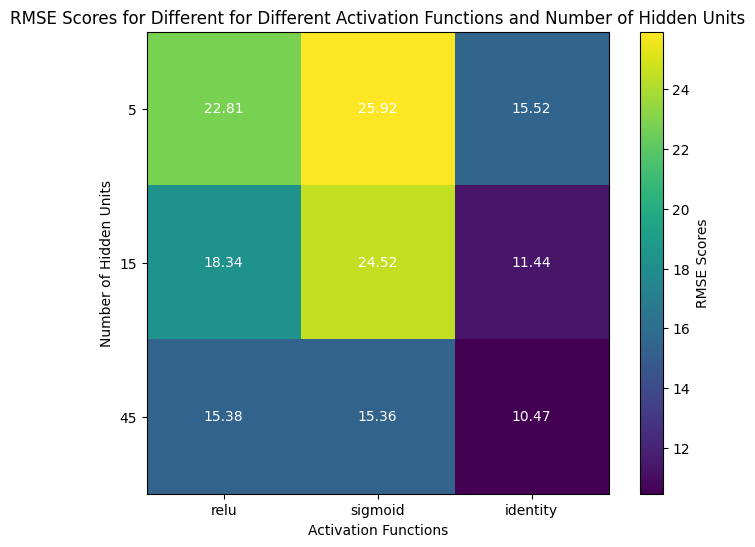

In [21]:
rmse_scores = np.array(rmse_scores).reshape(len(n_hidden_layers), len(activation_functions))

plt.figure(figsize=(8, 6))
plt.imshow(rmse_scores, cmap='viridis', interpolation='nearest')
plt.colorbar(label='RMSE Scores')

plt.xticks(np.arange(len(activation_functions)), activation_functions)
plt.yticks(np.arange(len(n_hidden_units)), n_hidden_units)
plt.xlabel('Activation Functions')
plt.ylabel('Number of Hidden Units')

# Add text annotations for each cell
for i in range(len(n_hidden_units)):
    for j in range(len(activation_functions)):
        plt.text(j, i, f'{rmse_scores[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('RMSE Scores for Different for Different Activation Functions and Number of Hidden Units')
plt.show()

# Question 5: Build and train a neural network of your choice to predict BMI from the rest of your dataset. How low can you get RMSE and what design choices does RMSE seem to depend on?

In [22]:
rmse_scores = []
model = nn.Sequential(
    nn.Linear(D, 20),
    nn.ReLU(),
    nn.Linear(45, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)
loss_function = RMSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # built-in L2
one_layer_models.append({"model": model, "loss_function": loss_function, "optimizer": optimizer})


model = model_info["model"]
loss_function = model_info["loss_function"]
optimizer = model_info["optimizer"]

print("\nTraining starts")
losses = []
def train_model(model, criterion, optimizer, inputs, labels, num_epochs=1000):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        epoch_loss = loss.item()
        losses.append(epoch_loss)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
           print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

train_model(model, criterion=loss_function, optimizer=optimizer, inputs=X_train_tensor, labels=y_train_tensor)

metrics = estimate_auc_rmse_scores(model, X_test_tensor, y_test_tensor)
print(metrics[0])


Training starts
Epoch [1/1000], Loss: 10.6810
Epoch [101/1000], Loss: 7.4261
Epoch [201/1000], Loss: 7.1265
Epoch [301/1000], Loss: 6.9278
Epoch [401/1000], Loss: 6.7868
Epoch [501/1000], Loss: 6.6836
Epoch [601/1000], Loss: 6.6059
Epoch [701/1000], Loss: 6.5453
Epoch [801/1000], Loss: 6.4960
Epoch [901/1000], Loss: 6.4546
6.2396045


In [23]:
def estimate_auc_rmse_scores(model, input_tensor, true_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
    return (np.sqrt(mean_squared_error(true_labels.numpy(), outputs.squeeze().detach().numpy())), model)   

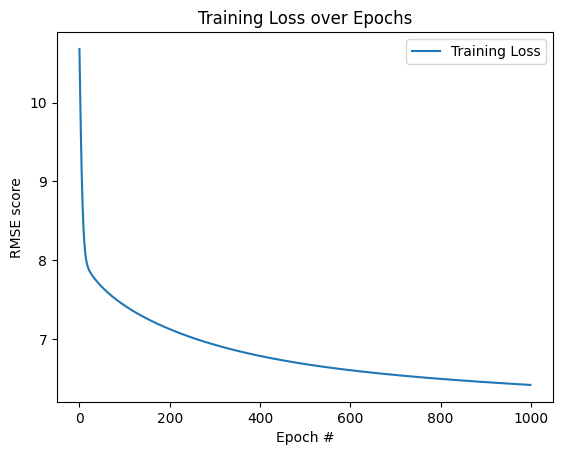

6.419357776641846


In [24]:
import matplotlib.pyplot as plt

plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('RMSE score')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

print(losses[-1])